In [1]:
import lancedb

In [2]:
def get_metadata_value(table, key_name, value_column="value"):
    """
    Retrieves a single value from a LanceDB table given a key.

    Args:
        table: The opened LanceDB table object.
        key_name: The string key to look for (e.g., 'tbl_img_emb').
        value_column: The name of the column containing the data.
    """
    # Filter for the key and select only the necessary column
    result = table.search().where(f"key='{key_name}'").select([value_column]).to_pandas()

    if not result.empty:
        return result[value_column].iloc[0]
    return None

In [3]:
embedding_db_path = "/glade/work/ncheruku/research/bams-ai-data-exploration/data/lancedb/experiments/clevr"
source_img_path = "/glade/work/ncheruku/research/bams-ai-data-exploration/data/lancedb/shared_source"

project_name = "clevr_dinov3"
src_img_tbl_name = "CLEVR_val_cropped"

# Connect and open table
db = lancedb.connect(embedding_db_path)
source_db = lancedb.connect(source_img_path)
config_tbl = db.open_table(project_name + "_config")
img_emb_tbl = db.open_table(get_metadata_value(config_tbl, "img_emb_table_current"))
patch_emb_tbl = db.open_table(get_metadata_value(config_tbl, "patch_emb_table_current"))
src_img_tbl = source_db.open_table(src_img_tbl_name)

df = patch_emb_tbl.to_pandas()
df
# patch_emb_tbl.count_rows()

,patch_id,image_id,patch_index,embedding
0,fe306d46237a8469dfe0ab9a210bc4fd:0,fe306d46237a8469dfe0ab9a210bc4fd,0,"[0.023254395, -0.011428833, -0.052734375, -0.0..."
1,fe306d46237a8469dfe0ab9a210bc4fd:1,fe306d46237a8469dfe0ab9a210bc4fd,1,"[0.037200928, -0.008781433, -0.04437256, -0.01..."
2,fe306d46237a8469dfe0ab9a210bc4fd:2,fe306d46237a8469dfe0ab9a210bc4fd,2,"[0.04156494, -0.0016450882, -0.042663574, -0.0..."
3,fe306d46237a8469dfe0ab9a210bc4fd:3,fe306d46237a8469dfe0ab9a210bc4fd,3,"[0.044525146, 0.004005432, -0.03704834, -0.030..."
4,fe306d46237a8469dfe0ab9a210bc4fd:4,fe306d46237a8469dfe0ab9a210bc4fd,4,"[0.037628174, -0.007888794, -0.052612305, -0.0..."
...,...,...,...,...
416763,4c88958d3dd685d6b5c269d52aad8348:251,4c88958d3dd685d6b5c269d52aad8348,251,"[0.052246094, -0.011741638, 0.006290436, -0.01..."
416764,4c88958d3dd685d6b5c269d52aad8348:252,4c88958d3dd685d6b5c269d52aad8348,252,"[0.06677246, -0.012084961, 0.015914917, -0.003..."
416765,4c88958d3dd685d6b5c269d52aad8348:253,4c88958d3dd685d6b5c269d52aad8348,253,"[0.07147217, -0.014083862, 0.024368286, 0.0045..."
416766,4c88958d3dd685d6b5c269d52aad8348:254,4c88958d3dd685d6b5c269d52aad8348,254,"[0.062927246, -0.010787964, 0.03024292, 0.0046..."


In [4]:
src_img_tbl.schema
# patch_emb_tbl= db.open_table(get_metadata_value(config_tbl, "patch_emb_table_current"))

id: string
filename: string
image_blob: binary
thumb_blob: binary
-- schema metadata --
dataset_info: '{"dataset_name": "CLEVR ", "description": "CLEVR validatio' + 363
version: '1.0'

In [5]:
patch_emb_tbl.schema

patch_id: string
image_id: string
patch_index: int32
embedding: fixed_size_list<item: float>[768]
  child 0, item: float

In [6]:
# CPU based

# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA

# # Materialize embeddings to a contiguous float32 matrix
# X = np.asarray(df["embedding"].to_list(), dtype=np.float32)  # shape (N, 768)

# pca = PCA(n_components=768, svd_solver="randomized", random_state=0)
# pca.fit(X)

# cum = np.cumsum(pca.explained_variance_ratio_)

# plt.figure()
# plt.plot(np.arange(1, 769), cum)
# plt.xlabel("Number of principal components")
# plt.ylabel("Cumulative explained variance ratio")
# plt.ylim(0, 1.01)
# plt.grid(True)

# for t in [0.80, 0.90, 0.95, 0.99]:
#     k = int(np.searchsorted(cum, t) + 1)
#     plt.axhline(t, linestyle="--",color="red" )
#     plt.text(768 * 0.65, t + 0.01, f"{int(t*100)}% @ {k} PCs")

# plt.show()


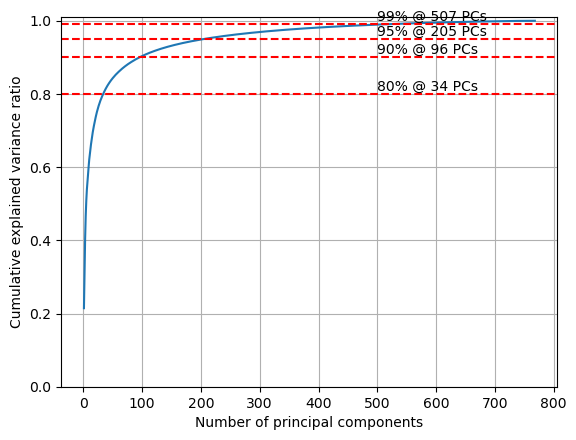

In [7]:
# GPU based

import matplotlib.pyplot as plt
import numpy as np
from cuml.decomposition import PCA

# Convert embeddings → contiguous float32 matrix
X = np.asarray(df["embedding"].to_list(), dtype=np.float32)

# GPU PCA
pca = PCA(n_components=768, output_type="numpy")
pca.fit(X)

# Cumulative explained variance
cum = np.cumsum(pca.explained_variance_ratio_)

# Plot
plt.figure()
plt.plot(np.arange(1, 769), cum)
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance ratio")
plt.ylim(0, 1.01)
plt.grid(True)

for t in [0.80, 0.90, 0.95, 0.99]:
    k = int(np.searchsorted(cum, t) + 1)
    plt.axhline(t, linestyle="--", color="red")
    plt.text(768 * 0.65, t + 0.01, f"{int(t * 100)}% @ {k} PCs")

plt.show()

In [8]:
X = np.asarray(df["embedding"].to_list(), dtype=np.float32)  # (N, 768)
patch_ids = df["patch_id"].to_numpy()

In [9]:
from cuml.decomposition import PCA as cuPCA

pca = cuPCA(n_components=320, output_type="numpy")
X363 = pca.fit_transform(X).astype(np.float32)  # (N, 363)

In [10]:
import pandas as pd
from cuml.manifold import UMAP as cuUMAP

umap = cuUMAP(
    n_components=2,
    n_neighbors=30,  # tweak
    min_dist=0.05,  # tweak
    metric="cosine",
    output_type="numpy",
    random_state=42,
)
XY = umap.fit_transform(X363).astype(np.float32)  # (N, 2)

In [11]:
# Convert to Arrow, select columns, then to Pandas
img_df = src_img_tbl.to_arrow().select(["id", "dt"]).to_pandas()

# Ensure dtype and build lookup
img_df["dt"] = pd.to_datetime(img_df["dt"])

image_to_dt = dict(zip(img_df["id"], img_df["dt"], strict=False), strict=False)

KeyError: 'Field "dt" does not exist in schema'

In [ ]:
patch_df = patch_emb_tbl.to_arrow().select(["image_id"]).to_pandas()

assert len(patch_df) == len(XY)

In [ ]:
image_ids = patch_df["image_id"].values

# Vectorized mapping
dt_for_point = pd.Series(image_ids).map(image_to_dt).values

In [ ]:
dt_series = pd.to_datetime(dt_for_point)

month_for_point = dt_series.month.astype("int8").values
doy_for_point = dt_series.dayofyear.astype("int16").values

In [ ]:
df_xy = pd.DataFrame(
    {
        "x": XY[:, 0],
        "y": XY[:, 1],
        "month": pd.Categorical(month_for_point),
        "doy": doy_for_point,
    }
)

In [ ]:
import datashader as ds
import holoviews as hv
import pandas as pd
import panel as pn
from holoviews.operation.datashader import datashade, dynspread

pn.extension()
hv.extension("bokeh")

# Points object
pts = hv.Points(df_xy, kdims=["x", "y"], vdims=["month", "doy"])


def make_plot(mode):
    if mode == "Month":
        color_key_month = {
            1: "#1f77b4",
            2: "#ff7f0e",
            3: "#2ca02c",
            4: "#d62728",
            5: "#9467bd",
            6: "#8c564b",
            7: "#e377c2",
            8: "#7f7f7f",
            9: "#bcbd22",
            10: "#17becf",
            11: "#aec7e8",
            12: "#ffbb78",
        }

        shaded = datashade(
            pts,
            aggregator=ds.count_cat("month"),
            color_key=color_key_month,
            width=3000,
            height=3000,
        )
        title = "UMAP Projection — Colored by Month"

    else:
        shaded = datashade(
            pts,
            aggregator=ds.mean("doy"),
            cmap="viridis",
            width=2000,
            height=2000,
        )
        title = "UMAP Projection — Colored by Day of Year"

    return dynspread(shaded).opts(
        width=1000,
        height=1000,
        bgcolor="#0e0e0e",
        show_grid=True,
        gridstyle={"grid_line_color": "#666666", "grid_line_alpha": 0.6},
        xlabel="UMAP-1",
        ylabel="UMAP-2",
        title=title,
    )


# Precompute both views
month_plot = make_plot("Month")
doy_plot = make_plot("Day of Year")

# Tabs layout - Assign to a variable and mark as servable
layout = pn.Tabs(
    ("Month", month_plot),
    ("DOY", doy_plot),
)

layout.servable()